In [1]:
import numpy as np
import pandas as pd
import os
import math
import sys
import matplotlib.pyplot as plt
# 1 min 15 sec

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning import Trainer, LightningDataModule
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
# 50 sec

In [3]:
sys.path.append('/groups/icecube/cyan/Utils')
from PlotUtils import setMplParam, getColour, getHistoParam 
# getHistoParam:
# Nbins, binwidth, bins, counts, bin_centers  = 
from DB_lister import list_content, list_tables
from ExternalFunctions import nice_string_output, add_text_to_ax
setMplParam()

In [4]:
test_dir = "/groups/icecube/cyan/factory/DOMification/PMTfied/test/"
test_source_DB_dir = test_dir + "testSource/"
test_PMTfied_DB_dir = "/groups/icecube/cyan/factory/DOMification/PMTfied/test/PMTfiedDB/"
test_PMTfied_parquet_dir = "/groups/icecube/cyan/factory/DOMification/PMTfied/test/PMTfiedParquet/"

QA_DB = test_source_DB_dir + "Level2_NuE_NuGenCCNC.022015.000110.db"
QA_DB_PMTfied = test_PMTfied_DB_dir + "voila.db"

ref_str_dom_pos = "/groups/icecube/cyan/factory/DOMification/unique_string_dom_completed.csv"

In [5]:
parquet_PMTfied = "/groups/icecube/cyan/factory/DOMification/PMTfied/test/PMTfiedParquet/combined_PMTfied.parquet"
parquet_truth   = "/groups/icecube/cyan/factory/DOMification/PMTfied/test/PMTfiedParquet/combined_truth.parquet"

I will tell more about the data. the PMTfied data has the features that I will feed the model. and one of the columns is 'event_no' which the truth data also has. I may want to do these: regression on columns: 'azimuth', 'zenith', or 'energy' or multiclass classification for 'pid'.

'azimuth', 'zenith', 'energy' and 'pid' are all columns of truth data

In [ ]:
df_sample_PMTfied = pd.read_parquet(parquet_PMTfied)
df_sample_truth = pd.read_parquet(parquet_truth)
print(df_sample_PMTfied.columns)
print(df_sample_truth.columns)
print(f"# of events in PMTfied: {df_sample_PMTfied['event_no'].nunique()}")
print(f"# of events in truth  : {df_sample_truth['event_no'].nunique()}")

Index(['event_no', 'dom_string', 'dom_number', 'dom_x', 'dom_y', 'dom_z',
       'dom_x_rel', 'dom_y_rel', 'dom_z_rel', 'pmt_area', 'rde',
       'saturation_status', 'q1', 'q2', 'q3', 'Q25', 'Q75', 'Qtotal', 'hlc1',
       'hlc2', 'hlc3', 't1', 't2', 't3', 'T10', 'T50', 'sigmaT'],
      dtype='object')
Index(['energy', 'position_x', 'position_y', 'position_z', 'azimuth', 'zenith',
       'pid', 'event_time', 'interaction_type', 'elasticity', 'RunID',
       'SubrunID', 'EventID', 'SubEventID', 'dbang_decay_length',
       'track_length', 'stopped_muon', 'energy_track', 'energy_cascade',
       'inelasticity', 'DeepCoreFilter_13', 'CascadeFilter_13',
       'MuonFilter_13', 'OnlineL2Filter_17', 'L3_oscNext_bool',
       'L4_oscNext_bool', 'L5_oscNext_bool', 'L6_oscNext_bool',
       'L7_oscNext_bool', 'Homogenized_QTot', 'MCLabelClassification',
       'MCLabelCoincidentMuons', 'MCLabelBgMuonMCPE',
       'MCLabelBgMuonMCPECharge', 'GNLabelTrackEnergyDeposited',
       'GNLabelTrackEne

In [7]:
def count_rows_per_event(df: pd.DataFrame) -> pd.DataFrame:
    event_counts = df.groupby('event_no').size().reset_index(name='count')
    max_count = event_counts['count'].max()
    return event_counts, max_count
pmt_counts, max_count_PMTfied = count_rows_per_event(df_sample_PMTfied)

In [8]:
pmt_counts

,event_no,count
0,0,231
1,1,368
2,2,574
3,3,304
4,4,67
...,...,...
1488,1488,243
1489,1489,24
1490,1490,393
1491,1491,961


In [ ]:
print(count_rows_per_event(df_sample_PMTfied))
print(count_rows_per_event(df_sample_truth))

(      event_no  count
0            0    231
1            1    368
2            2    574
3            3    304
4            4     67
...        ...    ...
1488      1488    243
1489      1489     24
1490      1490    393
1491      1491    961
1492      1492    105

[1493 rows x 2 columns], 2283)
(      event_no  count
0            0      1
1            1      1
2            2      1
3            3      1
4            4      1
...        ...    ...
1488      1488      1
1489      1489      1
1490      1490      1
1491      1491      1
1492      1492      1

[1493 rows x 2 columns], 1)


In [10]:
def plot_N_pmts_per_event(df: pd.DataFrame, title: str):
    Npmts, _ = count_rows_per_event(df)
    pmt_counts = Npmts['count']
    fig, ax = plt.subplots(figsize=(11, 7))
    ax.hist(pmt_counts, bins=50, range=(0, 500), histtype='step', label='PMTfied')
    ax.set_title(title)
    ax.set_xlabel('Number of PMTs per event')
    ax.set_ylabel('Number of events')
    ax.legend()
    d = {'mean': pmt_counts.mean(), 
        'std': pmt_counts.std(),
        'median': pmt_counts.median(),
        'min': pmt_counts.min(),
        'max': pmt_counts.max()}
    add_text_to_ax(0.75, 0.75, nice_string_output(d), ax, fontsize=12)

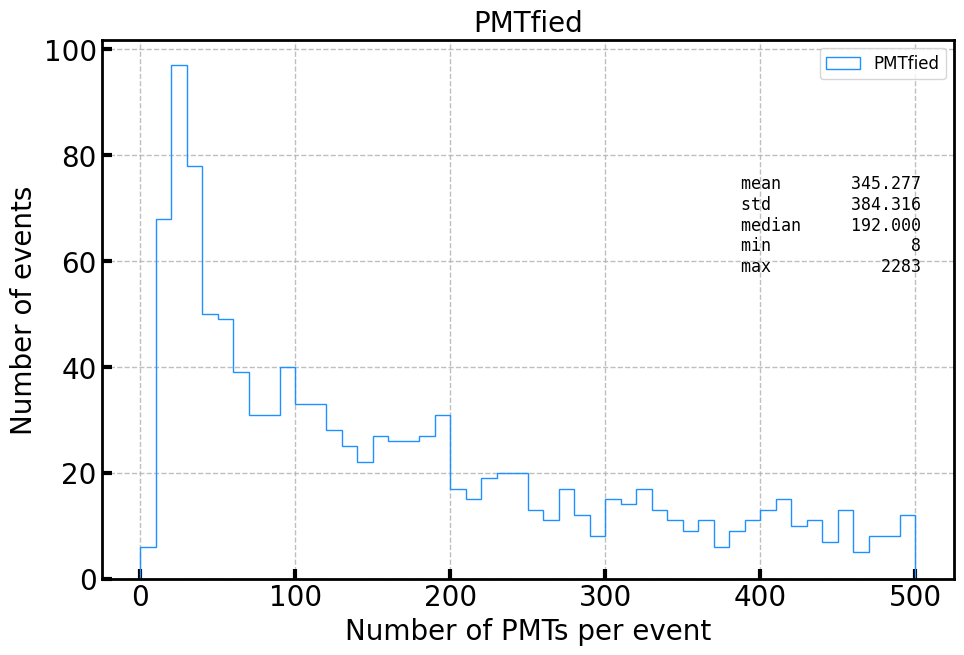

In [ ]:
plot_N_pmts_per_event(df_sample_PMTfied, 'PMTfied')

In [12]:
df_sample_PMTfied[:5]

,event_no,dom_string,dom_number,dom_x,dom_y,dom_z,dom_x_rel,dom_y_rel,dom_z_rel,pmt_area,...,Qtotal,hlc1,hlc2,hlc3,t1,t2,t3,T10,T50,sigmaT
0,366,1.0,58.0,-256.14,-521.08,-474.15,-86.827120,-176.637291,-152.218816,0.0444,...,0.475,1.0,-1.0,-1.0,17873.0,-1.0,-1.0,-1.0,-1.0,0.0
1,366,1.0,59.0,-256.14,-521.08,-491.17,-86.827120,-176.637291,-169.238816,0.0444,...,1.475,1.0,-1.0,-1.0,17456.0,-1.0,-1.0,-1.0,-1.0,0.0
2,366,3.0,53.0,-9.13,-481.74,-385.84,-6.777269,-357.599308,-264.921894,0.0444,...,0.575,0.0,-1.0,-1.0,16567.0,-1.0,-1.0,-1.0,-1.0,0.0
3,366,3.0,55.0,-9.13,-481.74,-419.89,-6.777269,-357.599308,-298.971894,0.0444,...,1.275,1.0,-1.0,-1.0,19182.0,-1.0,-1.0,-1.0,-1.0,0.0
4,366,3.0,57.0,-9.13,-481.74,-453.93,-6.777269,-357.599308,-333.011894,0.0444,...,0.475,1.0,-1.0,-1.0,19014.0,-1.0,-1.0,-1.0,-1.0,0.0


In [ ]:
df_sample_truth[:5]

,energy,position_x,position_y,position_z,azimuth,zenith,pid,event_time,interaction_type,elasticity,...,GNLabelCascadeEnergyDeposited,GNLabelEnergyDepositedTotal,GNLabelEnergyDepositedPrimary,GNHighestEInIceParticle,GNLabelHighestEInIceParticleIsChild,GNLabelHighestEInIceParticleDistance,GNLabelHighestEInIceParticleEFraction,GNLabelHighestEDaughterDistance,GNLabelHighestEDaughterEFraction,event_no
0,7.404683e+07,-1450.490939,-176.807603,1947.832512,3.322910,0.529491,14.0,1.306125e+17,1.0,-1.0,...,0.0,1.936160e+07,1.936160e+07,None,1.0,288.654369,0.963208,288.654369,0.963208,366
1,1.818134e+06,-5965.312566,86.417158,1945.208058,3.094503,1.259288,14.0,1.306125e+17,1.0,-1.0,...,0.0,5.545550e+04,5.545550e+04,None,1.0,195.924860,0.990416,195.924860,0.990416,367
2,1.055851e+07,82.125536,1955.980205,1947.699363,1.736027,0.780361,-14.0,1.306125e+17,2.0,-1.0,...,0.0,0.000000e+00,0.000000e+00,None,1.0,732.299623,0.101139,732.299623,0.101139,368
3,8.177518e+06,-863.614350,-2006.607027,1947.625651,3.964585,0.818611,14.0,1.306125e+17,1.0,-1.0,...,0.0,0.000000e+00,0.000000e+00,None,1.0,731.522965,0.984300,731.522965,0.984300,369
4,1.613618e+07,-132.101875,470.315912,1947.981280,1.667725,0.773946,14.0,1.306125e+17,2.0,-1.0,...,0.0,1.179511e+02,1.179511e+02,None,1.0,1495.181578,0.487799,1495.181578,0.487799,370


In [14]:
# pick unique event_no
event_ids = df_sample_PMTfied['event_no'].unique()

In [15]:
def divide_train_validation_test(event_ids, train_ratio=0.6, validation_ratio=0.2, test_ratio=0.2):
    n = len(event_ids)
    n_train = int(n * train_ratio)
    n_validation = int(n * validation_ratio)
    n_test = n - n_train - n_validation
    
    np.random.shuffle(event_ids)
    event_id_train = event_ids[:n_train]
    event_id_validation = event_ids[n_train:n_train + n_validation]
    event_id_test = event_ids[n_train + n_validation:]
    return event_id_train, event_id_validation, event_id_test
event_id_train, event_id_validation, event_id_test = divide_train_validation_test(event_ids)
print(f"# of events in train: {len(event_id_train)}")
print(f"# of events in validation: {len(event_id_validation)}")
print(f"# of events in test: {len(event_id_test)}")

# of events in train: 895
# of events in validation: 298
# of events in test: 300


In [16]:
def filter_data_by_event_ids(df, event_ids):
    return df[df['event_no'].isin(event_ids)]

def save_parquet(df, event_ids, file_name):
    selected_df = df[df['event_no'].isin(event_ids)]
    selected_df.to_parquet(file_name)

def split_train_validation_test(df_PMTfied, df_truth, event_id_train, event_id_validation, event_id_test):
    save_parquet(df_PMTfied, event_id_train, parquet_PMTfied.replace("combined", "train"))
    save_parquet(df_PMTfied, event_id_validation, parquet_PMTfied.replace("combined", "validation"))
    save_parquet(df_PMTfied, event_id_test, parquet_PMTfied.replace("combined", "test"))
    
    save_parquet(df_truth, event_id_train, parquet_truth.replace("combined", "train"))
    save_parquet(df_truth, event_id_validation, parquet_truth.replace("combined", "validation"))
    save_parquet(df_truth, event_id_test, parquet_truth.replace("combined", "test"))
split_train_validation_test(df_sample_PMTfied, df_sample_truth, event_id_train, event_id_validation, event_id_test)

In [17]:
class PMTDataset(Dataset):
    def __init__(self, pmtified_file_path, truth_file_path, target_column, max_pmts=5160):
        """
        Args:
            pmtified_file_path (str): Path to the PMTfied Parquet file.
            truth_file_path (str): Path to the truth Parquet file.
            target_column (str): Name of the target column in the truth Parquet file.
            max_pmts (int): Maximum number of PMTs per event to pad/truncate.
        """
        self.pmtified = pd.read_parquet(pmtified_file_path)
        self.truth = pd.read_parquet(truth_file_path)
        self.max_pmts = max_pmts
        self.target_column = target_column

        # Merge on event_no to align feature and truth data
        self.data = self.pmtified.merge(self.truth, on="event_no")
        self.event_ids = self.data["event_no"].unique()

    def __len__(self):
        return len(self.event_ids)

    def __getitem__(self, idx):
        # event_data: all rows for a single event
        event_id = self.event_ids[idx]
        event_data = self.data[self.data["event_no"] == event_id]

        # Define the columns to use as features, excluding the indices
        feature_columns = ['dom_x', 'dom_y', 'dom_z', 'dom_x_rel', 'dom_y_rel', 'dom_z_rel', 
                        'pmt_area', 'rde', 'saturation_status', 'q1', 'q2', 'q3', 
                        'Q25', 'Q75', 'Qtotal', 'hlc1', 'hlc2', 'hlc3', 
                        't1', 't2', 't3', 'T10', 'T50', 'sigmaT']

        # Extract PMT data using only the feature columns and convert to numpy array
        pmt_data = event_data[feature_columns].to_numpy()

        # Pad PMT data to a fixed length (max_pmts)
        pmt_data_padded = np.zeros((self.max_pmts, len(feature_columns)))
        pmt_data_padded[:min(self.max_pmts, pmt_data.shape[0]), :] = pmt_data[:self.max_pmts]

        # Extract target value (scalar, e.g., zenith, azimuth, or energy)
        target_data = event_data[self.target_column].iloc[0]

        # Convert to tensors
        pmt_tensor = torch.tensor(pmt_data_padded, dtype=torch.float32)
        target_tensor = torch.tensor(target_data, dtype=torch.float32)

        return pmt_tensor, target_tensor


In [18]:
def create_dataloader(pmtified_file_path, truth_file_path, target_column, batch_size=64, max_pmts=5160):
    dataset = PMTDataset(
        pmtified_file_path=pmtified_file_path,
        truth_file_path=truth_file_path,
        target_column=target_column,
        max_pmts=max_pmts
    )
    return DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

In [19]:
class RelativePositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(RelativePositionalEncoding, self).__init__()
        self.d_model = d_model

        # Create a matrix of size (max_len, d_model) for relative positions
        self.relative_positions = nn.Parameter(torch.randn(max_len, d_model))

    def forward(self, x):
        # x is of shape (batch_size, seq_length, d_model)
        batch_size, seq_length, _ = x.size()

        # Get the relative position encodings for the input sequence length
        positions = self.relative_positions[:seq_length, :]  # Shape: (seq_length, d_model)
        positions = positions.unsqueeze(0).repeat(batch_size, 1, 1)  # Shape: (batch_size, seq_length, d_model)

        return x + positions


In [20]:
class Transformer_PMT(pl.LightningModule):
    def __init__(self, input_dim, model_dim=128, n_heads=2, num_encoder_layers=3, lr=1e-4, max_pmts=5160):
        super(Transformer_PMT, self).__init__()
        self.model_dim = model_dim
        self.lr = lr
        self.max_pmts = max_pmts

        # Input Embedding
        self.embedding = nn.Linear(input_dim, model_dim)
        
        # Relative positional encoding
        self.relative_positional_encoding = RelativePositionalEncoding(d_model=model_dim, max_len=max_pmts)

        # Transformer Encoder Layer and Encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=n_heads, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        
        # Output MLP
        self.fc = nn.Linear(model_dim, 1)  # Output a single value for the target feature

    def forward(self, x):
        # Input shape: (batch_size, max_pmts, input_dim)
        batch_size, seq_len, _ = x.shape
        
        # Apply linear embedding to input data
        x = self.embedding(x)  # Shape: (batch_size, max_pmts, model_dim)

        # Apply relative positional encoding
        x = self.relative_positional_encoding(x)  # Shape: (batch_size, seq_len, model_dim)

        # Pass through the Transformer Encoder
        x = self.transformer_encoder(x)  # Shape: (batch_size, seq_len, model_dim)
        
        # Use mean pooling across the sequence dimension for regression
        x = x.mean(dim=1)
        x = self.fc(x).squeeze(-1)  # Output shape: (batch_size,)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.mse_loss(y_hat, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.mse_loss(y_hat, y)
        self.log('val_loss', loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)


In [21]:
root_dir = "/groups/icecube/cyan/factory/DOMification/PMTfied/test/PMTfiedParquet/"
train_feature_file = root_dir + "train_PMTfied.parquet"
train_truth_file = root_dir + "train_truth.parquet"
val_feature_file = root_dir + "validation_PMTfied.parquet"
val_truth_file = root_dir + "validation_truth.parquet"
test_feature_file = root_dir + "test_PMTfied.parquet"
test_truth_file = root_dir + "test_truth.parquet"

In [22]:
def run_training(batch_size=512, max_count_PMTfied = 5120):
    data_loader_train = create_dataloader(
        train_feature_file, 
        train_truth_file, 
        target_column="zenith", 
        batch_size=batch_size, 
        max_pmts=max_count_PMTfied
    )
    
    data_loader_val = create_dataloader(
        val_feature_file, 
        val_truth_file, 
        target_column="zenith", 
        batch_size=batch_size, 
        max_pmts=max_count_PMTfied
    )
    
    input_dim = next(iter(data_loader_train))[0].shape[-1]
    print(f"Input dimension: {input_dim}")

    model = Transformer_PMT(
        input_dim=input_dim,
        model_dim=128,
        n_heads=2,
        num_encoder_layers=3,
        lr=1e-4,
        max_pmts=max_count_PMTfied
    )
    
    checkpoint_callback = ModelCheckpoint(
        dirpath='checkpoints/',
        filename='best-checkpoint_211024_gpu',
        save_top_k=1,
        monitor='val_loss',
        mode='min'
    )

    # Define the Trainer with the checkpoint callback
    trainer = Trainer(
        max_epochs=10,
        accelerator='gpu',  # Change to 'gpu' and specify devices if using GPU
        # gpus=1, 
        callbacks=[checkpoint_callback]
    )
    
    trainer.fit(model, train_dataloaders=data_loader_train, val_dataloaders=data_loader_val)

    print("Training complete. Best model saved to checkpoints/")

In [23]:
run_training(batch_size=64, max_count_PMTfied=max_count_PMTfied)
# using cpu: 63 min 
# using gpu: 1 min 15 sec

Input dimension: 24


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/groups/icecube/cyan/.local/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3.9 /groups/icecube/cyan/.local/lib/python3.9/site-pa ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytor

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/groups/icecube/cyan/.local/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:475: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


/groups/icecube/cyan/.local/lib/python3.9/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (14) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 9: 100%|██████████| 14/14 [00:06<00:00,  2.04it/s, v_num=7]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 14/14 [00:06<00:00,  2.02it/s, v_num=7]
Training complete. Best model saved to checkpoints/


In [35]:
checkpoint_file = "/groups/icecube/cyan/factory/DOMification/checkpoints/best-checkpoint.ckpt"
checkpoint_file_gpu = "/groups/icecube/cyan/factory/DOMification/checkpoints/best-checkpoint_211024_gpu.ckpt"

In [36]:
def load_model(checkpoint_file, 
            input_dim, 
            model_dim=128, 
            n_heads=2, 
            num_encoder_layers=3, 
            lr=1e-4, 
            max_pmts=5160):
    """
    Loads a trained Transformer_PMT model from a checkpoint.

    Args:
        checkpoint_file (str): Path to the model checkpoint (.ckpt file).
        input_dim (int): The input dimension (number of PMT features).
        model_dim (int): Dimension of the model (d_model).
        n_heads (int): Number of attention heads.
        num_encoder_layers (int): Number of Transformer encoder layers.
        lr (float): Learning rate.
        max_pmts (int): Maximum number of PMTs per event.

    Returns:
        model: A loaded Transformer_PMT model.
    """
    model = Transformer_PMT.load_from_checkpoint(
        checkpoint_file,
        input_dim=input_dim,
        model_dim=model_dim,
        n_heads=n_heads,
        num_encoder_layers=num_encoder_layers,
        lr=lr,
        max_pmts=max_pmts
    )
    return model


In [51]:
def predict_zenith(model, data_loader, is_gpu=False):
    """
    Predicts zenith values using the provided model and data loader.

    Args:
        model: The trained PyTorch model.
        data_loader: DataLoader for the test set.
        is_gpu (bool): If True, moves the model and data to GPU for inference.

    Returns:
        predictions: List of predicted zenith values.
        true_values: List of true zenith values for reference.
    """
    model.eval()  # Set the model to evaluation mode
    if is_gpu:
        model.to('cuda')  # Move the model to the GPU if specified

    predictions = []
    true_values = []

    with torch.no_grad():
        for batch in data_loader:
            x, y = batch  # x: PMT data, y: true zenith values
            if is_gpu:
                # Move input data to the GPU
                x = x.to('cuda')
                y = y.to('cuda')

            # Make predictions
            y_hat = model(x)

            # Move predictions and true values back to CPU and convert to numpy arrays
            predictions.extend(y_hat.cpu().numpy())
            true_values.extend(y.cpu().numpy())

    return predictions, true_values


* Input dimension: 24

In [52]:
def run_inference(checkpoint_file,input_dim = 24, batch_size=64, max_count_PMTfied = 5120, is_gpu=True):
    model = load_model(
        checkpoint_file=checkpoint_file,  # Corrected parameter name
        input_dim=input_dim,
        model_dim=128,
        n_heads=2,
        num_encoder_layers=3,
        lr=1e-4,
        max_pmts=max_count_PMTfied
    )
    data_loader_test = create_dataloader(
        test_feature_file,
        test_truth_file,
        target_column="zenith",
        batch_size=batch_size,
        max_pmts=max_count_PMTfied
    )
    predictions, true_values = predict_zenith(model, data_loader_test, is_gpu=is_gpu)
    return predictions, true_values


In [55]:
zenith_predictions, zenith_true_values = run_inference(checkpoint_file, input_dim=24, batch_size=128, max_count_PMTfied=max_count_PMTfied, is_gpu=True)
# 30 sec: cup

In [56]:
zenith_predictions_gpu, zenith_true_values_gpu = run_inference(checkpoint_file_gpu, input_dim=24, batch_size=64, max_count_PMTfied=max_count_PMTfied, is_gpu=True)
# 

In [57]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
# 34sec

In [58]:
def calculate_metrics(predictions, true_values):
    mse = mean_squared_error(true_values, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(true_values, predictions)
    
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"Mean Absolute Error (MAE): {mae}")


In [59]:
calculate_metrics(zenith_predictions, zenith_true_values)

Mean Squared Error (MSE): 0.4284815490245819
Root Mean Squared Error (RMSE): 0.6545850038528442
Mean Absolute Error (MAE): 0.5241642594337463


first trial: not really good
* Mean Squared Error (MSE): 0.39979690313339233
* Root Mean Squared Error (RMSE): 0.6322949528694153
* Mean Absolute Error (MAE): 0.5071380138397217

second trial: not really good
* Mean Squared Error (MSE): 0.4284815490245819
* Root Mean Squared Error (RMSE): 0.6545850038528442
* Mean Absolute Error (MAE): 0.5241641998291016

In [60]:
calculate_metrics(zenith_predictions_gpu, zenith_true_values_gpu)

Mean Squared Error (MSE): 0.43145081400871277
Root Mean Squared Error (RMSE): 0.6568491458892822
Mean Absolute Error (MAE): 0.5205414891242981


In [32]:
zenith_true_values

[0.883848,
 1.4018643,
 1.328673,
 0.9371338,
 1.8244543,
 0.8270834,
 1.0510037,
 2.0851254,
 1.290511,
 2.9392276,
 0.9104472,
 1.0729557,
 0.91432923,
 1.4757454,
 1.6110171,
 0.9761612,
 2.2318692,
 0.41979602,
 1.2459911,
 1.3965304,
 0.6919176,
 1.2432116,
 1.7012666,
 1.8349795,
 0.8566518,
 1.3548198,
 0.6961318,
 0.5019093,
 0.3826584,
 0.1601464,
 2.663491,
 0.15706605,
 1.2221285,
 1.1443657,
 1.0251566,
 1.4886473,
 1.3295597,
 1.2241204,
 2.687572,
 1.55417,
 0.5794885,
 1.1257925,
 1.5003963,
 0.8383142,
 2.0012612,
 2.0652885,
 1.328847,
 1.5733519,
 2.142051,
 1.322076,
 1.100879,
 2.8070717,
 0.48992187,
 1.010023,
 0.25099444,
 1.1844147,
 0.5308334,
 1.9431434,
 0.22094397,
 1.0780749,
 0.97302157,
 2.6205826,
 0.90842915,
 2.949833,
 0.5159239,
 1.505467,
 2.4912696,
 2.0880625,
 1.5404963,
 1.7023903,
 0.6704713,
 0.95034224,
 1.8942566,
 2.2093325,
 1.0698935,
 0.91812235,
 0.5204125,
 1.4850851,
 0.31657693,
 0.86504817,
 0.30279678,
 1.2089319,
 1.1268202,
 1.02

* only encoder part of transformer
* relative position encoding
* multihead attention

* The data processing and splitting needs some modification.

In [33]:
'''
The PMTfied data has event-wise, PMT-wise summarised data.
Is splitting the data according to the event_no a proper way?
'''

'\nThe PMTfied data has event-wise, PMT-wise summarised data.\nIs splitting the data according to the event_no a proper way?\n'

In [34]:
df_sample_PMTfied
# df_sample_truth

,event_no,dom_string,dom_number,dom_x,dom_y,dom_z,dom_x_rel,dom_y_rel,dom_z_rel,pmt_area,...,Qtotal,hlc1,hlc2,hlc3,t1,t2,t3,T10,T50,sigmaT
0,366,1.0,58.0,-256.14,-521.08,-474.15,-86.827120,-176.637291,-152.218816,0.0444,...,0.475,1.0,-1.0,-1.0,17873.0,-1.0,-1.0,-1.0,-1.0,0.0
1,366,1.0,59.0,-256.14,-521.08,-491.17,-86.827120,-176.637291,-169.238816,0.0444,...,1.475,1.0,-1.0,-1.0,17456.0,-1.0,-1.0,-1.0,-1.0,0.0
2,366,3.0,53.0,-9.13,-481.74,-385.84,-6.777269,-357.599308,-264.921894,0.0444,...,0.575,0.0,-1.0,-1.0,16567.0,-1.0,-1.0,-1.0,-1.0,0.0
3,366,3.0,55.0,-9.13,-481.74,-419.89,-6.777269,-357.599308,-298.971894,0.0444,...,1.275,1.0,-1.0,-1.0,19182.0,-1.0,-1.0,-1.0,-1.0,0.0
4,366,3.0,57.0,-9.13,-481.74,-453.93,-6.777269,-357.599308,-333.011894,0.0444,...,0.475,1.0,-1.0,-1.0,19014.0,-1.0,-1.0,-1.0,-1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515493,1102,85.0,45.0,-9.68,-79.50,-394.70,-2.556981,-21.000002,-70.295828,0.0444,...,0.925,0.0,-1.0,-1.0,14793.0,-1.0,-1.0,-1.0,-1.0,0.0
515494,1102,85.0,51.0,-9.68,-79.50,-436.75,-2.556981,-21.000002,-112.345828,0.0444,...,0.675,0.0,-1.0,-1.0,14751.0,-1.0,-1.0,-1.0,-1.0,0.0
515495,1102,85.0,54.0,-9.68,-79.50,-457.78,-2.556981,-21.000002,-133.375828,0.0444,...,1.175,0.0,-1.0,-1.0,15685.0,-1.0,-1.0,-1.0,-1.0,0.0
515496,1102,85.0,57.0,-9.68,-79.50,-478.81,-2.556981,-21.000002,-154.405828,0.0444,...,1.325,1.0,-1.0,-1.0,14406.0,-1.0,-1.0,-1.0,-1.0,0.0
